<a href="https://colab.research.google.com/github/RtemShcherbak/Homeworks/blob/main/%D0%94%D0%97%E2%84%966_%D0%A9%D0%B5%D1%80%D0%B1%D0%B0%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Загрузка данных

## 1.1 Установка ключа и скачивание данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!rm -rf /content/face-expression-recognition-dataset.zip

In [ ]:
! kaggle datasets download jonathanoheix/face-expression-recognition-dataset

 87% 105M/121M [00:00<00:00, 176MB/s] 
100% 121M/121M [00:00<00:00, 187MB/s]


In [ ]:
!unzip face-expression-recognition-dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.j

In [ ]:
!rm -rf /content/images/images

# 2.Подключаемые модули

## 1.1 Библиотеки

In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 8.1 MB/s eta 0:00:00


In [ ]:
import copy
import random
import os
from collections import defaultdict

import matplotlib.pyplot as plt

import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2

import gc

from tqdm import tqdm

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

# 3.Custom DataLoader

В загруженном датасете структура папок выглядит так:

 images:

 --train:

 -------angry

 -------disgust

 ...

 -------surprise


 --validation:

 -------angry

 -------disgust

 ...

 -------surprise

Для распаковки картинок и последующей разметки написаны вспомогательные функции

In [ ]:
def give_file_paths(dataset_directory, root_directory, categories):
  """
  Изначально картинки рассортированы по папкам с соответствующими категориям
  названиями. Эта функция возвращает список абсолютных путей к картинкам из
  датасета.

  :param dataset_directory: путь к директории с датасетом
  :type dataset_directory: str

  :param root_directory: путь к  директории train или validatiion
  :type root_directory: str

  :param categories: список из названий папок, соответствующий категориям
  :type categories: list

  :raises None

  :rtype: list
  :return: list of file paths to images
  """

  dataset_directory = os.path.join(os.environ["HOME"], '/content/' + dataset_directory)
  root_directory = os.path.join(dataset_directory, root_directory)
  file_paths = []
  for category in categories:
    category_directory = os.path.join(root_directory, category)
    category_filepaths = sorted([os.path.join(category_directory, f) for f in os.listdir(category_directory)])
    for path in category_filepaths:
      file_paths.append(path)
  return file_paths

In [ ]:
categories = sorted(os.listdir(os.path.join(os.environ["HOME"], '/content/images/train')))
correct_images_filepaths = give_file_paths(dataset_directory = 'images', root_directory = 'train', categories = categories)
categories

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

Пример пути к картинке:

In [ ]:
correct_images_filepaths[0]

'/content/images/train/angry/0.jpg'

Посмотрим на распределение классов:

{'angry': 3993, 'disgust': 436, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}


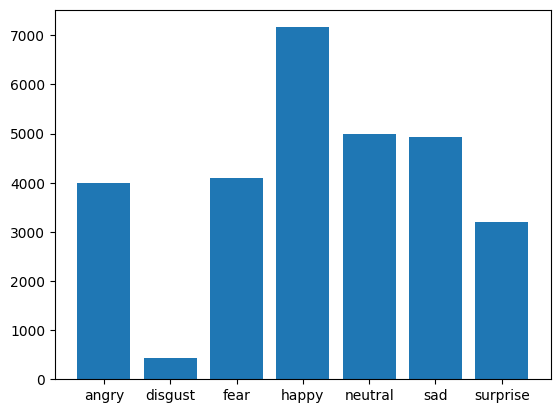

In [ ]:
cat_cols = {}
for category in categories:
  dir1 = os.path.join(os.path.join(os.environ["HOME"], '/content/images/train'), category)
  col = len(os.listdir(os.path.join(os.path.join(os.environ["HOME"], '/content/images/train'), category)))
  cat_cols.update({category: col})
print(cat_cols)
plt.bar(*zip(*cat_cols.items()))
plt.show()

Списки:

train_images_filepaths - список с путями к картинкам для train части

test_images_filepaths - список с путями к картинкам для test части

validation_images_filepaths - список с путями к картинкам для validation части

In [ ]:
random.seed(42)
random.shuffle(correct_images_filepaths)

train_size = int(len(correct_images_filepaths) * 0.8)
train_images_filepaths = correct_images_filepaths[:train_size]
test_images_filepaths = correct_images_filepaths[train_size:]

val_images_filepaths = give_file_paths(dataset_directory = 'images', root_directory = 'validation', categories = categories)

In [ ]:
print(len(train_images_filepaths), len(test_images_filepaths), len(val_images_filepaths))

23056 5765 7066


In [ ]:
def display_image_grid(images_filepaths, predicted_labels, cols=7):
    """
    Процедура создает сетку из картинок с подписанными категориями. Если
    категории из predicted_labels совпадает с реальными лейблами для картинок из
    списка images_filepaths, то лейблы отображаются зелёным, иначе - красным

    :param images_filepaths: список с путями к картинками
    :type images_filepaths: list

    :param predicted_labels: предсказанные категории
    :type predicted_labels: list

    :param cols: число отображённых картинок
    :type cols: int defaults to 7

    :raises None

    :rtype: None
    :return: None
    """
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    if len(images_filepaths) > 1:
      for i, image_filepath in enumerate(images_filepaths):
          image = cv2.imread(image_filepath)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
          predicted_label = predicted_labels[i] if predicted_labels else true_label
          color = "green" if true_label == predicted_label else "red"
          ax.ravel()[i].imshow(image)
          ax.ravel()[i].set_title(predicted_label, color=color)
          ax.ravel()[i].set_axis_off()
    else:
      i = 0
      image_filepath = images_filepaths[0]
      image = cv2.imread(image_filepath)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
      predicted_label = predicted_labels if predicted_labels else true_label
      color = "green" if true_label == predicted_label else "red"
      ax.imshow(image)
      ax.set_title(predicted_label, color=color)
      ax.set_axis_off()
    plt.tight_layout()
    plt.show()

Проверим работу функции display_image_grid. В списке predicted_labels реальные категории картинок, поэтому они отображаются зелёным.

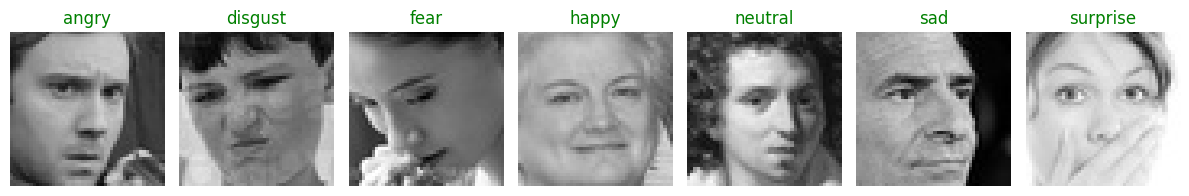

In [ ]:
categories = sorted(os.listdir(os.path.join(os.environ["HOME"], '/content/images/train')))
faces = []
for category in categories:
  dir1 = os.path.join(os.path.join(os.environ["HOME"], '/content/images/train'), category)
  img = sorted(os.listdir(os.path.join(os.path.join(os.environ["HOME"], '/content/images/train'), category)))[0]
  path = os.path.join(dir1, img)
  faces.append(path)
display_image_grid(faces)

Создаём датасеты

In [ ]:
class CDWDataset(Dataset):
    def __init__(self, categories, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        dct = {cat: i for i, cat in enumerate(categories)}
        label = dct[os.path.normpath(image_filepath).split(os.sep)[-2]]

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label

In [ ]:
image_size = 64

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(image_size, image_size),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RandomCrop(height=image_size, width=image_size),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = CDWDataset(categories = categories, images_filepaths = train_images_filepaths, transform=train_transform)

In [ ]:
val_transform = A.Compose(
    [
        A.Resize(image_size, image_size),
        A.CenterCrop(height=image_size, width=image_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = CDWDataset(categories=categories, images_filepaths=test_images_filepaths, transform=val_transform)
val_dataset = CDWDataset(categories=categories, images_filepaths=val_images_filepaths, transform=val_transform)

Взглянем на аугментированные картинки:

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    """
    Процедура создает сетку из аугментированных картинок.

    :param dataset: датасет с картинками
    :type dataset: CDWDataset()

    :param idx: индекс картинки в датасете
    :type idx: int

    :param samples: число отображённых картинок
    :type samples: int defaults to 10

    :param cols: число колонок
    :type cols: int defaults to 5


    :raises None

    :rtype: None
    :return: None
    """
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

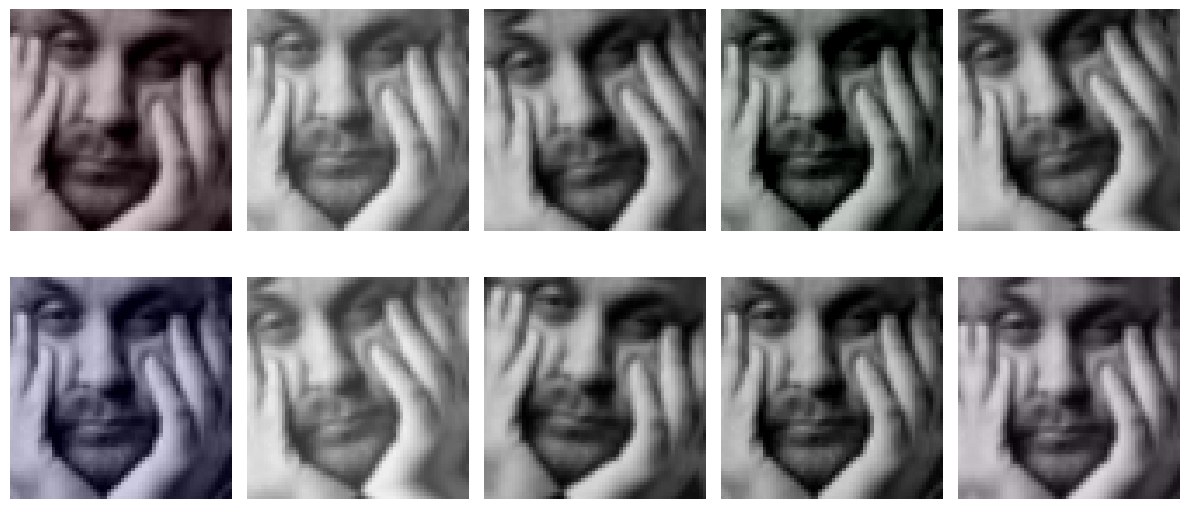

In [ ]:
random.seed(42)
visualize_augmentations(train_dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 2, pin_memory=True,)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 2, pin_memory=True)

# 4.Train function


In [ ]:
torch.cuda.is_available()

False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
class MetricMonitor:
    """
    Класс служит для хранения метрик, полученных в процессе обучения


    Attributes
    ----------
    float_precision : int
        точность результата

    Methods
    -------
    reset
        создаёт словарь со значениями метрики: текущем, среднем и счётчик значений
    update
        обновляет словарь метрики
    """

    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        """
        :param metric_name: имя метрики
        :type metric_name: str

        :param val: мгновенное значение метрики
        :type val: float

        :raises None

        :rtype: None
        :return: None
        """
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

def calculate_accuracy(preds, labels):
    """
    Функция служит для рассчёта accuracy

    :param preds: предсказанная разметка
    :type preds: numpy.array

    :param labels: реальная разметка
    :type labels: numpy.array

    :raises None

    :rtype: None
    :return: None
    """
    return torchmetrics.functional.accuracy(preds, labels, task="multiclass", num_classes=7)

In [ ]:
def train(net, train_loader, test_loader, criterion, optimizer, dir=None, n_epoch=2):
    best_accuracy = 0

    for epoch in range(n_epoch):

        net.train()
        stream = tqdm(train_loader)
        running_loss = 0.0
        metric_monitor = MetricMonitor()

        for i, batch in enumerate(stream):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            y_pred = net(images)
            loss = criterion(y_pred, labels)
            accuracy = calculate_accuracy(y_pred.detach().cpu(), labels.detach().cpu())

            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('Accuracy', accuracy)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            stream.set_description(
                "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
                )

        net.eval()
        stream1 = tqdm(test_loader)
        metric_monitor = MetricMonitor()
        with torch.no_grad():
          for i, batch in enumerate(stream1):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)

            y_pred = net(images)
            loss = criterion(y_pred, labels)
            accuracy = calculate_accuracy(y_pred, labels)

            metric_monitor.update('Loss', loss.item())
            metric_monitor.update('Accuracy', accuracy)
            stream1.set_description(
                "Epoch: {epoch}. Test.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
                )

            if accuracy > best_accuracy:
                if dir != None:
                  pth = './best_model' + dir + '.pt'
                else:
                  pth = './best_model.pt'
                torch.save(net.state_dict(), pth)
                best_accuracy = accuracy

    print('\nОбучение закончено')
    return net

Ниже приведены две вспомогательные функции: give_random_res служит для отображения случайного результата, give_ravel служит для отображения ряда результатов

In [ ]:
def give_random_res(model, categories):
  pic_number = np.random.randint(0, len(val_images_filepaths))

  img = val_dataset.__getitem__(pic_number)[0].unsqueeze(0)
  label = val_dataset.__getitem__(pic_number)[1]

  with torch.no_grad():
      y_pred = model(img)
  print(y_pred,
        #torch.nn.functional.softmax(y_pred, dim=1)
        )
  y_pred = np.argmax(y_pred.detach().numpy())
  print(y_pred)
  dct = {i: cat for i, cat in enumerate(categories)}

  display_image_grid([val_images_filepaths[pic_number]], predicted_labels=dct[y_pred], cols=1)

In [ ]:
def give_ravel(model, categories, x, y):
  labels_net = []
  with torch.no_grad():
    for images, labels in val_loader:
        labels_net.extend(model.forward(images).detach().numpy())
  dct = {i: cat for i, cat in enumerate(categories)}
  categorical_labels = []
  for label in np.argmax(np.array(labels_net), axis=1):
    categorical_labels.append(dct[label])
  display_image_grid(val_images_filepaths[x:x+y], categorical_labels[x:x+y])

# 5.Validate function

In [ ]:
def val(net, val_loader):
  accuracy_lst = []
  net.eval()
  stream1 = tqdm(val_loader)
  metric_monitor = MetricMonitor()
  with torch.no_grad():
    for i, batch in enumerate(stream1):
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)

      y_pred = net(images)

      accuracy = calculate_accuracy(y_pred, labels)
      accuracy_lst.append(accuracy)

      metric_monitor.update('Accuracy', accuracy)
      stream1.set_description(
          "Epoch: {epoch}. Test.      {metric_monitor}".format(epoch='Epoch0', metric_monitor=metric_monitor)
          )
  return accuracy_lst

# 6.Models

## 6.1 Efficientnet_b7

In [ ]:
efnet_b7 = models.efficientnet_b7(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:01<00:00, 134MB/s]


In [ ]:
class NewEfficientnetB7(nn.Module):
  def __init__(self):
    super().__init__()
    self.efnet = efnet_b7
    for parameter in self.efnet.features.parameters():
      parameter.requaires_grad = False
    self.fc = nn.Linear(1000, 7)

  def forward(self, x):
    x = self.efnet(x)
    x = self.fc(x)
    return x

In [ ]:
torch.cuda.empty_cache()
gc.collect()

print(torch.cuda.get_device_name())
net = NewEfficientnetB7().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

net = train(net, train_loader, test_loader, criterion, optimizer, dir = '_efnet_b7', n_epoch = 10)


Tesla T4


Epoch: 0. Train.      Loss: 1.627 | Accuracy: 0.363: 100%|██████████| 721/721 [02:20<00:00,  5.11it/s]
Epoch: 0. Test.      Loss: 1.298 | Accuracy: 0.507: 100%|██████████| 181/181 [00:17<00:00, 10.41it/s]
Epoch: 1. Train.      Loss: 1.262 | Accuracy: 0.518: 100%|██████████| 721/721 [02:20<00:00,  5.14it/s]
Epoch: 1. Test.      Loss: 1.152 | Accuracy: 0.570: 100%|██████████| 181/181 [00:11<00:00, 15.37it/s]
Epoch: 2. Train.      Loss: 1.111 | Accuracy: 0.582: 100%|██████████| 721/721 [02:20<00:00,  5.13it/s]
Epoch: 2. Test.      Loss: 1.079 | Accuracy: 0.598: 100%|██████████| 181/181 [00:11<00:00, 16.12it/s]
Epoch: 3. Train.      Loss: 0.995 | Accuracy: 0.623: 100%|██████████| 721/721 [02:20<00:00,  5.14it/s]
Epoch: 3. Test.      Loss: 1.057 | Accuracy: 0.598: 100%|██████████| 181/181 [00:11<00:00, 16.42it/s]
Epoch: 4. Train.      Loss: 0.895 | Accuracy: 0.668: 100%|██████████| 721/721 [02:20<00:00,  5.14it/s]
Epoch: 4. Test.      Loss: 1.037 | Accuracy: 0.624: 100%|██████████| 181/181 


Обучение закончено


In [ ]:
!cp best_model_efnet_b7.pt '/content/drive/MyDrive/Models/hw_6/'

## 6.2 Efficientnet_b0

In [ ]:
efnet_b0 = models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 156MB/s]


In [ ]:
class NewEfficientnetB0(nn.Module):
  def __init__(self):
    super().__init__()
    self.efnet = efnet_b0
    for parameter in self.efnet.features.parameters():
      parameter.requaires_grad = True
    self.fc = nn.Linear(1000, 7)

  def forward(self, x):
    x = self.efnet(x)
    x = self.fc(x)
    return x

In [ ]:
torch.cuda.empty_cache()
gc.collect()

print(torch.cuda.get_device_name())
net = NewEfficientnetB0().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

net = train(net, train_loader, test_loader, criterion, optimizer, dir = '_efnet', n_epoch = 10)


Tesla T4


Epoch: 0. Train.      Loss: 1.369 | Accuracy: 0.484: 100%|██████████| 721/721 [00:40<00:00, 17.75it/s]
Epoch: 0. Test.      Loss: 1.247 | Accuracy: 0.526: 100%|██████████| 181/181 [00:06<00:00, 29.37it/s]
Epoch: 1. Train.      Loss: 1.230 | Accuracy: 0.533: 100%|██████████| 721/721 [00:41<00:00, 17.44it/s]
Epoch: 1. Test.      Loss: 1.173 | Accuracy: 0.554: 100%|██████████| 181/181 [00:04<00:00, 38.36it/s]
Epoch: 2. Train.      Loss: 1.156 | Accuracy: 0.561: 100%|██████████| 721/721 [00:41<00:00, 17.48it/s]
Epoch: 2. Test.      Loss: 1.134 | Accuracy: 0.580: 100%|██████████| 181/181 [00:04<00:00, 39.59it/s]
Epoch: 3. Train.      Loss: 1.096 | Accuracy: 0.584: 100%|██████████| 721/721 [00:41<00:00, 17.25it/s]
Epoch: 3. Test.      Loss: 1.088 | Accuracy: 0.592: 100%|██████████| 181/181 [00:04<00:00, 40.56it/s]
Epoch: 4. Train.      Loss: 1.033 | Accuracy: 0.609: 100%|██████████| 721/721 [00:41<00:00, 17.45it/s]
Epoch: 4. Test.      Loss: 1.082 | Accuracy: 0.594: 100%|██████████| 181/181 


Обучение закончено


In [ ]:
!cp best_model_efnet_all.pt '/content/drive/MyDrive/Models/hw_6/'

# 7.Дистилляция


## 7.1 Distillation train function

In [ ]:
def distill(student, teacher, optimizer, train_loader, test_loader, num_epoch, alpha, T, dir = None):

  teacher = teacher.eval()

  best_accuracy = 0.0

  for epoch in range(num_epoch):
    student.train()
    stream = tqdm(train_loader)
    metric_monitor = MetricMonitor()

    for i, batch in enumerate(stream):
      images, labels = batch
      images = images.to(device)
      labels = labels.to(device)

      y_pred = student(images)

      with torch.no_grad():
        teacher_output = teacher(images)

      teacher_output.requaires_grad = False

      loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(y_pred/T, dim=1),
                                                 F.softmax(teacher_output/T, dim=1)) * (alpha * T * T) + \
                                                 F.cross_entropy(y_pred, labels) * (1. - alpha)

      accuracy = calculate_accuracy(y_pred.detach().cpu(), labels.detach().cpu())

      metric_monitor.update('Loss', loss.item())
      metric_monitor.update('Accuracy', accuracy)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      stream.set_description(
          "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
      )

    student.eval()
    stream1 = tqdm(test_loader)
    with torch.no_grad():
      for i, batch in enumerate(stream1):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        y_pred = student(images)
        teacher_output = teacher(images)
        teacher_output.requaires_grad = False
        loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(y_pred/T, dim=1),
                                                   F.softmax(teacher_output/T, dim=1)) * (alpha * T * T) +\
                                                   F.cross_entropy(y_pred, labels) * (1. - alpha)

        accuracy = calculate_accuracy(y_pred.detach().cpu(), labels.detach().cpu())

        metric_monitor.update('Loss', loss.item())
        metric_monitor.update('Accuracy', accuracy)

        stream1.set_description(
            "Epoch: {epoch}. Test.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

        if accuracy > best_accuracy:
          if dir != None:
            pth = './best_model_student' + dir + '.pt'
          else:
            pth = './best_model_student.pt'
          torch.save(student.state_dict(), pth)
          best_accuracy = accuracy

  print('\n Обучение закончено')
  return net

## 7.2 Student Model

In [ ]:
mob = models.mobilenet_v3_small(pretrained=False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
class NewMob(nn.Module):
  def __init__(self):
    super().__init__()
    self.mob = mob
    for parameter in self.mob.features.parameters():
      parameter.requaires_grad = True
    self.fc = nn.Linear(1000, 7)

  def forward(self, x):
    x = self.mob(x)
    x = self.fc(x)
    return x

In [ ]:
torch.cuda.empty_cache()
gc.collect()

print(torch.cuda.get_device_name())
net = NewMob().to(device)

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

net = train(net, train_loader, test_loader, criterion, optimizer, dir = '_mob', n_epoch = 10)

Tesla T4


  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]


Обучение закончено


In [ ]:
!cp best_model_mob.pt '/content/drive/MyDrive/Models/hw_6/'

## 7.3 Distillation

In [ ]:
teacher = NewEfficientnetB0().to('cpu')
teacher.load_state_dict(torch.load('/content/drive/MyDrive/Models/hw_6/best_model_efnet_all.pt'))
teacher.eval()
pass

In [ ]:
torch.cuda.empty_cache()
gc.collect()

print(torch.cuda.get_device_name())

student = NewMob()
teacher = NewEfficientnetB0().to('cpu')
teacher.load_state_dict(torch.load('/content/drive/MyDrive/Models/hw_6/best_model_efnet_all.pt'))

student = student.to(device)
teacher = teacher.to(device)

optimizer = torch.optim.Adam(net.parameters(), lr = 1e-4)

distill(student, teacher, optimizer, train_loader, test_loader, num_epoch=10, alpha=0.8, T=1.2, dir='_st')
pass

Tesla T4


  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/181 [00:00<?, ?it/s]


 Обучение закончено


In [ ]:
!cp best_model_student_st.pt '/content/drive/MyDrive/Models/hw_6/'

#8.Onnx

In [ ]:
pip install onnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 38.1 MB/s eta 0:00:00


In [ ]:
pip install onnxruntime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00


In [ ]:
import onnx
import torch.onnx
import onnxruntime
import torch.quantization

In [ ]:
sorted(os.listdir('drive/MyDrive/Models/hw_6'))

['best_model_efnet.pt',
 'best_model_efnet_all.pt',
 'best_model_efnet_b7.pt',
 'best_model_mob.pt',
 'best_model_student_st.pt',
 'efnetb0.onnx']

In [ ]:
def to_numpy(tensor):
  """Функция переводит tensor в numpy.array"""
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


def convert_model_to_onnx(model, model_name, dir):
  """
  Функция служит для конфертации модели в onnx формат

  :param model: предобученная модель которая будет конвертирована в onnx
  :type model: nn.Module

  :param model_name: имя модели после конвертации
  :type model_name: str

  :param dir: папка для сохранения
  :type dir: str

  :raises None

  :rtype: None
  :return: None
  """
  dummy_input = torch.randn(1, 3, 64, 64)
  input_names = [ "input" ]
  output_names = [ "output" ]
  torch.onnx.export(model,
                    dummy_input,
                    dir + model_name + '.onnx',
                    verbose=False,
                    input_names=input_names,
                    output_names=output_names,
                    export_params=True,
                    )


def time_of_function(function):
  """
  Декратор для расчёта времени работы функции

  :param function: функция для декорации
  :type function: function
  """

    def wrapped(*args):
        start_time = time.perf_counter_ns()
        res = function(*args)
        #print(time.perf_counter_ns() - start_time)
        return res, ((time.perf_counter_ns() - start_time) / 10 ** 9)
    return wrapped


@time_of_function
def onnx_result(dir, model_name, image):
  """
  Функция служит для отображения результата из onnx модели и подсчёта времени,
  необходимого для этого

  :param dir: папка в которой лежит модель
  :type dir: str

  :param model_name: имя модели
  :type model_name: str

  :param image:
  :type image: str

  :raises None

  :rtype: str
  :return: категорию картинки
  """

  ort_session = onnxruntime.InferenceSession(dir + model_name + '.onnx')
  ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
  ort_outs = ort_session.run(None, ort_inputs)
  img_out_y = ort_outs[0]
  return img_out_y


@time_of_function
def pt_result(dir, model_name, stract, image):
  """
  Функция служит для отображения результата из pt модели и подсчёта времени,
  необходимого для этого

  :param dir: папка в которой лежит модель
  :type dir: str

  :param model_name: имя модели
  :type model_name: str

  :param stract: архитектура модели
  :type stract: --

  :param image:
  :type image: str

  :raises None

  :rtype: str
  :return: категорию картинки
  """

  model = stract.to('cpu')
  model.load_state_dict(torch.load(dir + model_name + '.pt', map_location=torch.device(device)))
  model.eval()
  return model(image)


In [ ]:
stracts = [NewEfficientnetB0(),
           NewEfficientnetB0(),
           NewEfficientnetB7(),
           NewMob(),
           NewMob()]

torch_models = sorted(os.listdir('drive/MyDrive/Models/hw_6'))[:5]

In [ ]:
dir = 'drive/MyDrive/Models/proba/'

for i, model_name in enumerate(torch_models):
  model = stracts[i].to('cpu')
  model.load_state_dict(torch.load('drive/MyDrive/Models/hw_6/' + model_name))
  model.eval()
  convert_model_to_onnx(model, model_name[:-3], dir)


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ================

# 9.Результаты

In [ ]:
models = sorted(
    ['best_model_efnet',
    'best_model_efnet_all',
    'best_model_efnet_b7',
    'best_model_mob',
    'best_model_student_st']
    )

pic_number = 100
img = val_dataset.__getitem__(pic_number)[0].unsqueeze(0)
label = val_dataset.__getitem__(pic_number)[1]

results = {}
for i, model_name in enumerate(models):

  res = []
  model = stracts[i].to('cpu')
  model.load_state_dict(torch.load('drive/MyDrive/Models/hw_6/' + model_name + '.pt', map_location=torch.device(device)))
  model.eval()

  acc = val(model, val_loader)
  acc = [i.cpu().numpy() for i in acc]
  res.append(np.mean(acc))

  t = pt_result('drive/MyDrive/Models/hw_6/', model_name, stracts[i], img)[1]
  res.append(t)
  res.append(os.path.getsize('/content/drive/MyDrive/Models/hw_6/' + model_name + '.pt'))
  results.update({model_name: res})

  res = []
  res.append('--')
  t = onnx_result('drive/MyDrive/Models/proba/', model_name, img)[1]
  res.append(t)
  res.append(os.path.getsize('/content/drive/MyDrive/Models/proba/' + model_name + '.onnx'))
  results.update({model_name + '_onnx': res})


print(results)

Epoch: Epoch0. Test.      Accuracy: 0.470: 100%|██████████| 221/221 [00:13<00:00, 16.40it/s]


{'best_model_efnet': [0.5146189, 0.09977621, 21487801], 'best_model_efnet_onnx': ['--', 0.097854614, 21177965], 'best_model_efnet_all': [0.6296119, 0.104674625, 21487801], 'best_model_efnet_all_onnx': ['--', 0.104204774, 21177965], 'best_model_efnet_b7': [0.6368561, 0.768536709, 267127319], 'best_model_efnet_b7_onnx': ['--', 1.072684136, 265071094], 'best_model_mob': [0.42127132, 0.058912776, 10336605], 'best_model_mob_onnx': ['--', 0.075001691, 10211121], 'best_model_student_st': [0.4696963, 0.059847144, 10338341], 'best_model_student_st_onnx': ['--', 0.0801244, 10211121]}


In [ ]:
import pandas as pd
df = pd.DataFrame.from_dict(results, orient='index'). reset_index()
df.columns = ['Model', 'Accuracy', 'Time', 'Memory']
df

,Model,Accuracy,Time,Memory
0,best_model_efnet,0.514619,0.099776,21487801
1,best_model_efnet_onnx,--,0.097855,21177965
2,best_model_efnet_all,0.629612,0.104675,21487801
3,best_model_efnet_all_onnx,--,0.104205,21177965
4,best_model_efnet_b7,0.636856,0.768537,267127319
5,best_model_efnet_b7_onnx,--,1.072684,265071094
6,best_model_mob,0.421271,0.058913,10336605
7,best_model_mob_onnx,--,0.075002,10211121
8,best_model_student_st,0.469696,0.059847,10338341
9,best_model_student_st_onnx,--,0.080124,10211121


# 10.Выводы

Были использованы три различных архитектуры: Effcicientnet_B0, Efficientnet_B7 и MobileNet_v3. В качестве модели студента выступала сеть MobileNet_v3.

1. При обучении всех весов модели Effcicientnet_B0 она почти сравнялась по accuracy с предуобученной моделью Efficientnet_B7;

2. Скорость работы модели Effcicientnet_B0 выше, чем Efficientnet_B7, поэтому она была взята в качестве модели-учителя;

3. Обученная с учителем модель MobileNet_v3 даёт результат 0.47, против 0,42 у модели, обучавшейся без учителя;

4. Конвертация модели в onnx-формат даёт незначительный выигрыш в памяти;

5. Конвертация модели в onnx-формат не показывает значительного прироста в скорости инференса, однако это может быть связано с особенностями работы Collab`a;